In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotmap import DotMap
from pathlib import Path
from collections.abc import Mapping, Iterable

from IPython.display import display

%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Naming conventions

For easier reading, the following naming conventions are used. The templates are written as shell file template

+ `df_*` denotes an pandas.DataFrame
+ `dfs_*` denotes any dict-like mapping from names to pandas.DataFrame

Those naming conventions also holds for helper function signatures

# Config

In [2]:
DATA = Path("./data")

# Load Standards

Flags provide additional info on how the values in datasets where obtained

In [3]:
df_flags = pd.read_csv(
    DATA / "definitions_and_standards/flags.csv",
    keep_default_na=False,
    index_col="Flag"
)

The same country code are used in all of FAOSTAT datasets. As datasets contains aggregated data on country groups, loading that dataframe will allow to remove aggregated data.

In [4]:
df_area_groups = pd.read_csv(
    DATA / "definitions_and_standards/country_group.csv"
)

# Load datas

## Helper Functions

In [17]:
# Helper function
from src.utils import *

#snake case conversion
_first_cap_re = re.compile("(\w)([A-Z][a-z]+)")
_all_cap_re = re.compile("([a-z0-9])([A-Z])")
_space_between = re.compile("(\W*) ([a-z]*)")


def to_snakecase(name):
    s1 = _first_cap_re.sub(r"\1_\2", name)
    s2 = _all_cap_re.sub(r"\1_\2", s1).lower()
    s3 = _space_between.sub(r"\1_\2", s2)
    return s3.replace(" ", "").replace("__", "_")

def join_flags(df, filepath, df_flags):
    df["Flag"] = pd.read_csv(filepath, encoding="latin1", usecols=["Flag"], keep_default_na=False)
    return df.merge(df_flags, on="Flag").drop(columns="Flag").rename(columns={"Flags": "Flag"})

def split_on(df, column, rename={}, only_named=False, drop=[]):
    """
    Splits a dataframe in multiple dataframe based on the value of a columne
    
    Args:
        df: dataframe to spli
        column: name of the column to split on
        rename (optional): mapping or callable that rename values to name in the final dictionary
        only_named (False): keep only dataframe with a value in column that is renamed
        drop: drop columns in resulting dataframes (useful for redundant columns)
    
    Returns:
        A dictionnary mapping unique values in df[column] to the dataframe with that value.
        Value (i.e. dict keys) can be renamed by the rename argument. A callable can return None to not rename it.
    """
    result = DotMap(_dynamic=False)
    if not isinstance(drop, Iterable) or isinstance(drop, str):
        drop = [drop]
    for value in df[column].unique():
        if callable(rename):
            name = rename(value)
        elif isinstance(rename, Mapping):
            name = rename.get(value)
        else:
            name = None
        if name is None and only_named:
            continue
        result[name or value] = df[ df[column] == value].drop(columns=drop + [column])
    return result

## Animal emissions data

## Computed emissions data

In [18]:
# load base info, drop redundant year code column
df_env_emission_intensity = pd.read_csv(
    DATA / "global-food-agriculture-statistics/raw_files/Environment_Emissions_intensities_E_All_Data_(Normalized).csv",
    encoding="latin1",
).drop("Year Code", axis="columns")

# reload the flags to rpevent NaN collison on flags "" and "NA", and replace by their meaning
df_env_emission_intensity = join_flags(
    df_env_emission_intensity,
    DATA / "global-food-agriculture-statistics/raw_files/Environment_Emissions_intensities_E_All_Data_(Normalized).csv",
    df_flags
)

#Remove aggreagated data
df_env_emission_intensity = remove_country_group(df_env_emission_intensity, df_area_groups)

# Split on the Element column
dfs_env_em_intensity = split_on(
    df_env_emission_intensity, "Element",
    drop="Element Code",
    rename=to_snakecase
)
del df_env_emission_intensity
    
for table_name, df in dfs_env_em_intensity.items():
    print(f"\n\nTable {table_name}")
    print(f"  - Units: {', '.join(df['Unit'].unique())}")
    if table_name == "emissions_intensity":
        print("  - Available products:", end="\n      ")
        for k, prod in enumerate(df['Item'].unique()):
            print("%-23s" % prod, end="\n      " if k % 3 == 2 else "\t\t")
        print()
    print("  - Sample of 10 values:")
    display(df.sample(10))



Table emissions_intensity
  - Units: kg CO2eq/kg product
  - Available products:
      Cereals excluding rice 		Rice, paddy            		Meat, cattle           
      Milk, whole fresh cow  		Meat, goat             		Milk, whole fresh goat 
      Meat, sheep            		Milk, whole fresh sheep		Milk, whole fresh camel
      Meat, chicken          		Eggs, hen, in shell    		Milk, whole fresh buffalo
      Meat, pig              		Meat, buffalo          		
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Year,Unit,Value,Flag
31622,115,Cambodia,867,"Meat, cattle",2005,kg CO2eq/kg product,81.6350,Calculated data
150594,174,Portugal,1062,"Eggs, hen, in shell",2002,kg CO2eq/kg product,0.3890,Calculated data
22126,80,Bosnia and Herzegovina,1062,"Eggs, hen, in shell",1998,kg CO2eq/kg product,1.7272,Calculated data
12964,16,Bangladesh,882,"Milk, whole fresh cow",1971,kg CO2eq/kg product,6.6979,Calculated data
25219,26,Brunei Darussalam,867,"Meat, cattle",2004,kg CO2eq/kg product,0.5841,Calculated data
26850,27,Bulgaria,947,"Meat, buffalo",1975,kg CO2eq/kg product,13.0850,Calculated data
161112,191,Saint Vincent and the Grenadines,1062,"Eggs, hen, in shell",1975,kg CO2eq/kg product,0.6597,Calculated data
53761,250,Democratic Republic of the Congo,867,"Meat, cattle",1989,kg CO2eq/kg product,63.2696,Calculated data
165943,196,Seychelles,882,"Milk, whole fresh cow",1965,kg CO2eq/kg product,3.1748,Calculated data
105130,120,Lao People's Democratic Republic,1035,"Meat, pig",2006,kg CO2eq/kg product,8.4530,Calculated data




Table emissions_(co2eq)
  - Units: gigagrams
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Year,Unit,Value,Flag
157110,184,Rwanda,1718,Cereals excluding rice,1964,gigagrams,15.8440,Calculated data
25032,239,British Virgin Islands,1035,"Meat, pig",2008,gigagrams,0.3589,Calculated data
57916,56,Dominican Republic,1062,"Eggs, hen, in shell",1973,gigagrams,15.0579,Calculated data
57459,56,Dominican Republic,882,"Milk, whole fresh cow",2006,gigagrams,734.7268,Calculated data
197241,240,United States Virgin Islands,882,"Milk, whole fresh cow",1990,gigagrams,1.4109,Calculated data
181411,212,Syrian Arab Republic,1062,"Eggs, hen, in shell",1975,gigagrams,26.8956,Calculated data
43581,44,Colombia,1062,"Eggs, hen, in shell",1999,gigagrams,146.7243,Calculated data
95757,105,Israel,1035,"Meat, pig",1979,gigagrams,35.7703,Calculated data
5130,7,Angola,1017,"Meat, goat",2008,gigagrams,779.3686,Calculated data
206019,251,Zambia,1718,Cereals excluding rice,1963,gigagrams,145.5566,Calculated data




Table production
  - Units: tonnes
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Year,Unit,Value,Flag
319477,195,Senegal,1035,"Meat, pig",2006,tonnes,10316.0,Official data
343018,214,"China, Taiwan Province of",1062,"Eggs, hen, in shell",2014,tonnes,343960.0,Unofficial figure
329691,19,Bolivia (Plurinational State of),977,"Meat, sheep",2007,tonnes,19500.0,FAO estimate
316700,173,Poland,1035,"Meat, pig",1963,tonnes,1111000.0,Official data
350961,60,El Salvador,1017,"Meat, goat",2003,tonnes,62.0,FAO data based on imputation methodology
338467,191,Saint Vincent and the Grenadines,1062,"Eggs, hen, in shell",1977,tonnes,480.0,FAO estimate
356067,153,New Caledonia,1017,"Meat, goat",1995,tonnes,51.0,FAO data based on imputation methodology
304413,97,Hungary,982,"Milk, whole fresh sheep",2000,tonnes,3200.0,Official data
235109,214,"China, Taiwan Province of",1718,Cereals excluding rice,1964,tonnes,72850.0,"Aggregate, may include official, semi-official..."
359467,219,Tonga,1017,"Meat, goat",2013,tonnes,27.0,FAO data based on imputation methodology


[]

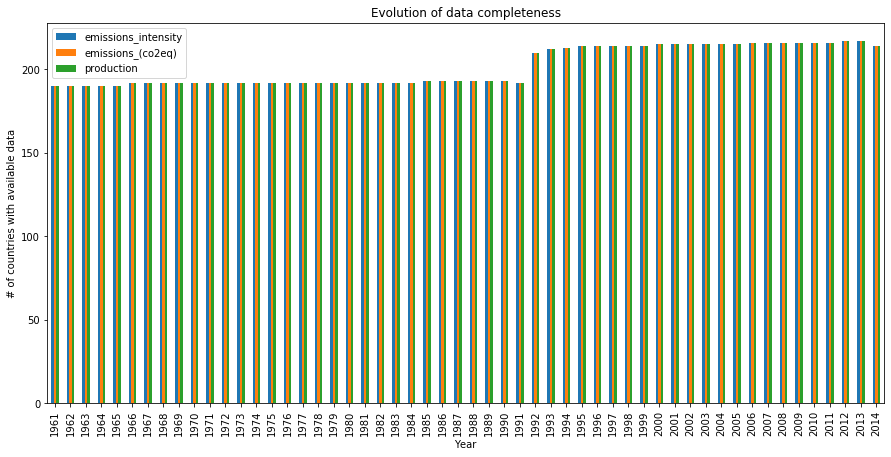

In [19]:
plot_completeness_histogram(dfs_env_em_intensity, figsize=(15, 7))
plt.plot()

The above histogram showing how complete the data are (number of country with data as a function of time) shows that the data are quite complete. Somme countries seems to have been added in 1992, let's find those.

In [20]:
df = dfs_env_em_intensity.production
df_before = df[ df["Year"] == 1991]
df_after = df[ df["Year"] == 1992]

set(df_after["Area"].unique()) - set(df_before["Area"].unique())

{'Armenia',
 'Azerbaijan',
 'Belarus',
 'Bosnia and Herzegovina',
 'Croatia',
 'Estonia',
 'Georgia',
 'Kazakhstan',
 'Kyrgyzstan',
 'Latvia',
 'Lithuania',
 'Republic of Moldova',
 'Russian Federation',
 'Serbia and Montenegro',
 'Slovenia',
 'Tajikistan',
 'The former Yugoslav Republic of Macedonia',
 'Turkmenistan',
 'Ukraine',
 'Uzbekistan'}

This is due to the dilution of the URSS. This will require special handling in the analysis and visualization: the choice of countries to use will most likely be done on a per year basis.

## Productions

In [23]:
# Load, remove duplicate column "year code"
df_prod_animals = pd.read_csv(
    DATA / "global-food-agriculture-statistics/raw_files/Production_LivestockPrimary_E_All_Data_(Normalized).csv",
    encoding="latin1"
).drop(columns="Year Code")

# Join the flag column with the standard meaning
df_prod_animals = join_flags(
    df_prod_animals,
    DATA / "global-food-agriculture-statistics/raw_files/Production_LivestockPrimary_E_All_Data_(Normalized).csv",
    df_flags
)

#remove aggregated data
df_prod_animals = remove_country_group(df_prod_animals, df_area_groups)

# Harmonise units
## 1000 Head -> Head
unit_filter = df_prod_animals["Unit"] == "1000 Head"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].multiply(1000)
df_prod_animals.loc[unit_filter, "Unit"] = "Head"

## 1000 No -> No
unit_filter = df_prod_animals["Unit"] == "1000 No"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].multiply(1000)
df_prod_animals.loc[unit_filter, "Unit"] = "No"

## 100mg/An 0.1g/An -> g/An
unit_filter = df_prod_animals["Unit"].isin(["100mg/An", "0.1g/An"])
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].div(10)
df_prod_animals.loc[unit_filter, "Unit"] = "g/An"

## hg/An -> kg/An
unit_filter = df_prod_animals["Unit"] == "hg/An"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].div(10)
df_prod_animals.loc[unit_filter, "Unit"] = "kg/An"

## hg -> kg
unit_filter = df_prod_animals["Unit"] == "hg"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].div(10)
df_prod_animals.loc[unit_filter, "Unit"] = "kg"

# Split according to Element column
dfs_prod_animals = split_on(
    df_prod_animals,
    "Element",
    rename=to_snakecase
)


for table_name, df in dfs_prod_animals.items():
    print(f"\n\nTable {table_name}")
    print(f"  - Units: {', '.join(df['Unit'].unique())}")
    print("  - Sample of 10 values:")
    display(df.sample(10))



Table laying
  - Units: Head
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
918691,223,Turkey,1783,Eggs Primary,5313,1974,Head,17500000.0,"Aggregate, may include official, semi-official..."
239733,276,Sudan,1062,"Eggs, hen, in shell",5313,2013,Head,9223000.0,Official data
838868,81,Ghana,1783,Eggs Primary,5313,2002,Head,8800000.0,"Aggregate, may include official, semi-official..."
79385,129,Madagascar,1062,"Eggs, hen, in shell",5313,2004,Head,3500000.0,FAO estimate
118903,197,Sierra Leone,1062,"Eggs, hen, in shell",5313,1976,Head,1675000.0,FAO estimate
847227,97,Hungary,1783,Eggs Primary,5313,1971,Head,29699000.0,"Aggregate, may include official, semi-official..."
108511,117,Republic of Korea,1091,"Eggs, other bird, in shell",5313,1972,Head,125000.0,FAO estimate
77107,123,Liberia,1062,"Eggs, hen, in shell",5313,1985,Head,800000.0,FAO estimate
930540,248,Yugoslav SFR,1783,Eggs Primary,5313,1978,Head,34423000.0,"Aggregate, may include official, semi-official..."
881851,160,Niue,1783,Eggs Primary,5313,2010,Head,4000.0,"Aggregate, may include official, semi-official..."




Table production
  - Units: tonnes, No, Head
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
410368,95,Honduras,977,"Meat, sheep",5510,1972,tonnes,3.000000e+01,Calculated data
744909,133,Mali,1062,"Eggs, hen, in shell",5510,1990,tonnes,1.188000e+04,FAO data based on imputation methodology
192803,100,India,1067,"Eggs, hen, in shell (number)",5513,1973,No,7.700000e+09,Official data
257154,248,Yugoslav SFR,1062,"Eggs, hen, in shell",5510,1988,tonnes,2.250000e+05,Official data
605984,229,United Kingdom,1097,"Meat, horse",5510,1984,tonnes,6.822000e+03,Calculated data
163794,33,Canada,882,"Milk, whole fresh cow",5510,1965,tonnes,8.335949e+06,Official data
432594,110,Japan,1120,"Meat indigenous, horse",5510,1972,tonnes,6.882000e+03,Calculated data
801929,29,Burundi,1808,"Meat, Poultry",5510,1976,tonnes,3.645000e+03,"Aggregate, may include official, semi-official..."
322230,40,Chile,1087,"Meat indigenous, turkey",5510,2010,tonnes,9.253400e+04,Calculated data
775205,126,Lithuania,1070,"Meat indigenous, duck",5510,1992,tonnes,NaN,Data not available




Table producing_animals/slaughtered
  - Units: Head
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
789618,12,Bahamas,1808,"Meat, Poultry",5321,2000,Head,5600000.0,"Aggregate, may include official, semi-official..."
67973,103,Iraq,1017,"Meat, goat",5320,1987,Head,630000.0,FAO estimate
833132,67,Finland,1806,Beef and Buffalo Meat,5320,1964,Head,1114600.0,"Aggregate, may include official, semi-official..."
231516,184,Rwanda,867,"Meat, cattle",5320,1974,Head,80000.0,Official data
819287,48,Costa Rica,1808,"Meat, Poultry",5321,1998,Head,43660000.0,"Aggregate, may include official, semi-official..."
754347,146,Republic of Moldova,1141,"Meat, rabbit",5321,2003,Head,144000.0,FAO data based on imputation methodology
57477,88,Guam,1035,"Meat, pig",5320,1971,Head,3350.0,FAO estimate
728924,45,Comoros,977,"Meat, sheep",5320,2000,Head,5500.0,FAO data based on imputation methodology
766565,251,Zambia,867,"Meat, cattle",5320,1999,Head,370000.0,FAO data based on imputation methodology
190749,97,Hungary,867,"Meat, cattle",5320,1963,Head,500000.0,Official data




Table milk_animals
  - Units: Head
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
185623,79,Germany,882,"Milk, whole fresh cow",5318,1972,Head,7588754.0,Official data
907558,203,Spain,1780,"Milk,Total",5318,2008,Head,4707610.0,"Aggregate, may include official, semi-official..."
856,2,Afghanistan,1020,"Milk, whole fresh goat",5318,1990,Head,1340000.0,FAO estimate
139160,215,United Republic of Tanzania,882,"Milk, whole fresh cow",5318,2011,Head,6900000.0,FAO estimate
257714,248,Yugoslav SFR,982,"Milk, whole fresh sheep",5318,1986,Head,3849616.0,Official data
145306,249,Yemen,982,"Milk, whole fresh sheep",5318,2013,Head,2922000.0,FAO estimate
161108,27,Bulgaria,882,"Milk, whole fresh cow",5318,1970,Head,545552.0,Official data
859264,120,Lao People's Democratic Republic,1780,"Milk,Total",5318,1970,Head,12600.0,"Aggregate, may include official, semi-official..."
108264,179,Qatar,1020,"Milk, whole fresh goat",5318,1981,Head,23000.0,FAO estimate
748671,28,Myanmar,982,"Milk, whole fresh sheep",5318,2010,Head,147975.0,FAO data based on imputation methodology




Table prod_popultn
  - Units: Head, No
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
781838,251,Zambia,1182,"Honey, natural",5314,1996,No,NaN,Data not available
778980,174,Portugal,1182,"Honey, natural",5314,2005,No,NaN,Data not available
765912,243,Wallis and Futuna Islands,1182,"Honey, natural",5314,2011,No,570.0,FAO data based on imputation methodology
248975,223,Turkey,987,"Wool, greasy",5319,2010,Head,23089691.0,Official data
45710,62,Ethiopia PDR,1183,Beeswax,5314,1977,No,3167000.0,FAO estimate
773987,102,Iran (Islamic Republic of),1185,"Silk-worm cocoons, reelable",5319,2002,Head,NaN,Data not available
172434,50,Cyprus,987,"Wool, greasy",5319,2008,Head,292000.0,Official data
772926,68,France,1185,"Silk-worm cocoons, reelable",5319,2004,Head,NaN,Data not available
65825,101,Indonesia,987,"Wool, greasy",5319,1966,Head,3680000.0,FAO estimate
766358,249,Yemen,1182,"Honey, natural",5314,2014,No,173407.0,FAO data based on imputation methodology




Table yield
  - Units: g/An, kg/An, kg
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
310258,29,Burundi,1025,"Skins, goat, fresh",5420,1979,kg/An,2.5,Calculated data
432114,110,Japan,1062,"Eggs, hen, in shell",5410,1969,g/An,14912.2,Calculated data
503429,159,Nigeria,1783,Eggs Primary,5410,2011,g/An,4575.5,Calculated data
329129,41,"China, mainland",957,"Hides, buffalo, fresh",5420,2001,kg/An,30.0,Calculated data
482711,28,Myanmar,1062,"Eggs, hen, in shell",5410,2013,g/An,6063.5,Calculated data
336368,45,Comoros,919,"Hides, cattle, fresh",5420,2010,kg/An,20.0,Calculated data
259300,2,Afghanistan,882,"Milk, whole fresh cow",5420,2013,kg/An,370.2,Calculated data
577988,210,Sweden,995,"Skins, sheep, fresh",5420,1969,kg/An,1.6,Calculated data
485024,28,Myanmar,982,"Milk, whole fresh sheep",5420,1991,kg/An,23.1,Calculated data
571146,38,Sri Lanka,951,"Milk, whole fresh buffalo",5420,1980,kg/An,569.1,Calculated data




Table yield/carcass_weight
  - Units: kg/An, g/An
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
597583,223,Turkey,1087,"Meat indigenous, turkey",5424,1983,g/An,2000.0,Calculated data
363156,58,Ecuador,1141,"Meat, rabbit",5424,1973,g/An,1400.0,Calculated data
629964,181,Zimbabwe,1808,"Meat, Poultry",5424,1979,g/An,1153.4,Calculated data
277826,12,Bahamas,1035,"Meat, pig",5417,1984,kg/An,50.0,Calculated data
500795,158,Niger,1058,"Meat, chicken",5424,2014,g/An,800.0,Calculated data
409148,93,Haiti,1808,"Meat, Poultry",5424,2009,g/An,914.3,Calculated data
282871,14,Barbados,1012,"Meat indigenous, sheep",5417,1962,kg/An,14.0,Calculated data
274860,11,Austria,1058,"Meat, chicken",5424,1986,g/An,1344.8,Calculated data
532321,146,Republic of Moldova,1087,"Meat indigenous, turkey",5424,1999,g/An,6087.0,Calculated data
490809,150,Netherlands,1012,"Meat indigenous, sheep",5417,1991,kg/An,24.4,Calculated data


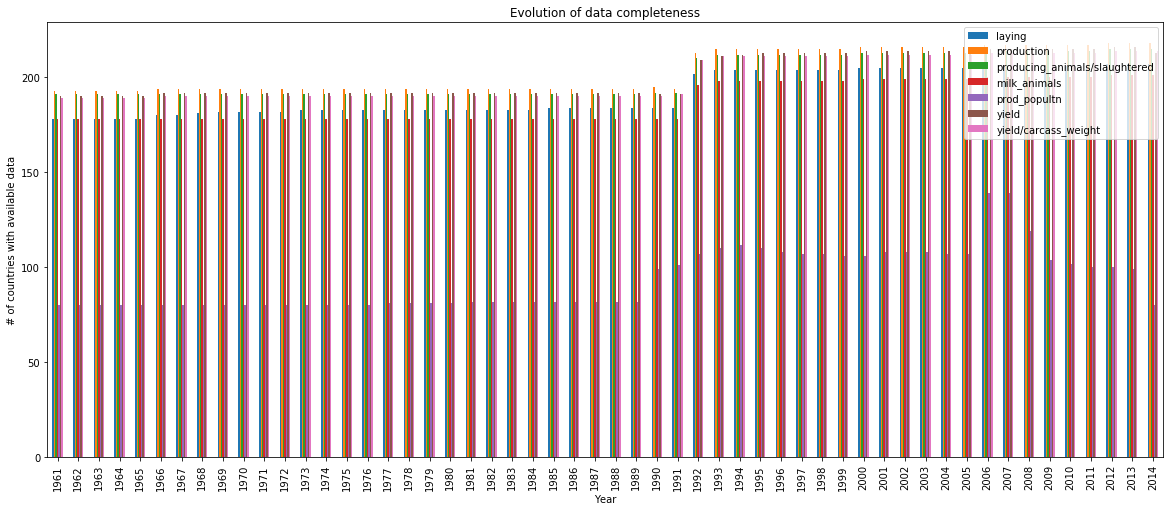

In [24]:
plot_completeness_histogram(dfs_prod_animals, figsize=(20,8))

The above bar plot shows that the `prod_popultn` Table has a lot of missing countries. Given the data it holds, namely the production of `['Wool, greasy', 'Honey, natural', 'Beeswax', 'Silk-worm cocoons, reelable', 'Hair, horse']`, this is not a problem.

The tables we are mostly interested in are `production`, `yield` and `producing_animals/slaughtered`, so we will have to consider only contries at least in those three tables.

## Trade data